In [1]:
# all tensorflow api is accessible through this
import tensorflow as tf
import numpy as np
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data

Extracting input/data/train-images-idx3-ubyte.gz
Extracting input/data/train-labels-idx1-ubyte.gz
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz
y = 7 (Sneaker)


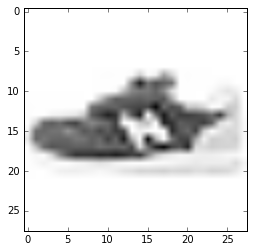

y = 1 (Trouser)


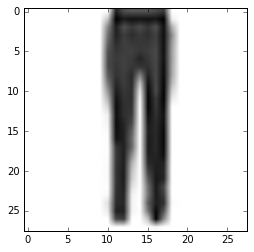

In [2]:
tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/data', one_hot=True)

label_dict = {
 0: 'T-shirt-top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# Get 28x28 image
sample_1 = mnist.train.images[183].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_1 = np.where(mnist.train.labels[183] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()

# Sample 2

# Get 28x28 image
sample_2 = mnist.train.images[190].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_2 = np.where(mnist.train.labels[190] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_2, label=label_dict[sample_label_2]))
plt.imshow(sample_2, cmap='Greys')
plt.show()

In [37]:
# Parameters
learning_rate = 0.005
training_iters = 10000
batch_size = 100
test_step = 100

# Network Parameters
n_input = 28 * 28
n_classes = 10
dropout = .75 # Dropout, probability to keep units

# 1. Define Variables and Placeholders
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

weights = {
    
    'wd1': tf.Variable(tf.random_normal([n_input, 200])),
    'wd2': tf.Variable(tf.random_normal([200, 100])),
    'wd3': tf.Variable(tf.random_normal([100, 60])),
    'wd4': tf.Variable(tf.random_normal([60, 30])),
    'out': tf.Variable(tf.random_normal([30, n_classes])),

}

biases = {
    
    'bd1': tf.Variable(tf.random_normal([200])),
    'bd2': tf.Variable(tf.random_normal([100])),
    'bd3': tf.Variable(tf.random_normal([60])),
    'bd4': tf.Variable(tf.random_normal([30])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# 2. Define the model
def build_model(x, weights, biases, dropout, activation):

    fc1 = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])
    fc1 = activation(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = activation(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    fc3 = activation(fc3)
    fc3 = tf.nn.dropout(fc3, dropout)
    
    fc4 = tf.add(tf.matmul(fc3, weights['wd4']), biases['bd4'])
    fc4 = activation(fc4)
    fc4 = tf.nn.dropout(fc4, dropout)
    
    out = tf.add(tf.matmul(fc4, weights['out']), biases['out'])

    return out

predictions = build_model(x, weights, biases, keep_prob, activation=tf.sigmoid)
# 3. Define the loss function  
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))

# 4. Define the accuracy 
correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 5. Define an optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [38]:
train_accuracy = []
train_cost = []
test_accuracy = []
test_cost = []

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step < training_iters:
        
        batch_x, batch_y = mnist.train.next_batch(batch_size)
            
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        if step % test_step == 0:
            # Calculate batch loss and accuracy
            train_loss, train_acc = sess.run([cost, accuracy], feed_dict={x: batch_x, 
                                                                          y: batch_y,
                                                                            keep_prob: 1.0})
            
            train_cost.append(train_loss)
            train_accuracy.append(train_acc)
            
            print ("Batch " + str(step) + ", batch Loss= " + \
                  "{:.6f}".format(train_loss) + ", batch Accuracy= " + \
                  "{:.5f}".format(train_acc))
            
            test_loss, test_acc = sess.run([cost, accuracy], feed_dict={x: mnist.test.images, 
                                                                        y: mnist.test.labels,
                                                                       keep_prob: 1.0})
            test_cost.append(test_loss)
            test_accuracy.append(test_acc)
            print ("Test set loss:", test_loss, 'test set acc: ', test_acc)
            print('-' * 60)

        step += 1
            
    print ("Optimization Finished!")

    # Calculate accuracy for all test samples
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y: mnist.test.labels,
                                     keep_prob: 1.0}))

Batch 100, batch Loss= 1.653987, batch Accuracy= 0.46000
Test set loss: 1.7279 test set acc:  0.4092
------------------------------------------------------------
Batch 200, batch Loss= 1.051438, batch Accuracy= 0.66000
Test set loss: 1.19365 test set acc:  0.5793
------------------------------------------------------------
Batch 300, batch Loss= 0.953798, batch Accuracy= 0.63000
Test set loss: 1.01576 test set acc:  0.6232
------------------------------------------------------------
Batch 400, batch Loss= 1.058436, batch Accuracy= 0.58000
Test set loss: 0.925593 test set acc:  0.6408
------------------------------------------------------------
Batch 500, batch Loss= 0.738506, batch Accuracy= 0.76000
Test set loss: 0.874424 test set acc:  0.6518
------------------------------------------------------------
Batch 600, batch Loss= 0.807829, batch Accuracy= 0.74000
Test set loss: 0.848302 test set acc:  0.6687
------------------------------------------------------------
Batch 700, batch Los

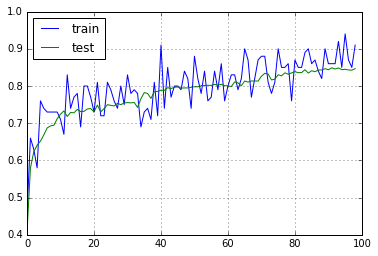

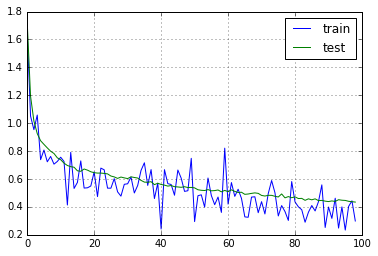

In [39]:
# 7. Plot and visualise the accuracy and loss

def plot_accuracy_and_cost(save_fig=False):
    
    # accuracy training vs testing dataset
    plt.plot(train_accuracy)
    plt.plot(test_accuracy)
    plt.grid(True)
    plt.legend(['train', 'test'], loc='best')
    
    if save_fig:
        plt.savefig('./output_images/task 3/task_3_accuracy_sigmoid.png')
    plt.show()

    # loss training vs testing dataset
    plt.plot(train_cost)
    plt.plot(test_cost)
    plt.grid(True)
    plt.legend(['train', 'test'], loc='best')
    
    if save_fig:
        plt.savefig('./output_images/task 3/task_3_cost_sigmoid.png')
    plt.show()

#     # Zoom in on the tail of the plots
#     zoom_point = 50
#     x_range = list(range(zoom_point, int(training_iters/test_step)-1))
#     plt.plot(x_range, train_accuracy[zoom_point:])
#     plt.plot(x_range, test_accuracy[zoom_point:])
#     plt.grid(True)
#     plt.legend(['train', 'test'], loc='best')
#     if save_fig:
#         plt.savefig('./output_images/task 3/task_2_accuracy_relu_zoomed.png')
#     plt.show()

#     plt.plot(train_cost[zoom_point:])
#     plt.plot(test_cost[zoom_point:])
#     plt.grid(True)
#     plt.legend(['train', 'test'], loc='best')
#     if save_fig:
#         plt.savefig('./output_images/task 3/task_2_cost_relu_zoomed.png')
#     plt.show()
    
plot_accuracy_and_cost(save_fig=True)

# Task 1
## Q1: What loss and accuracy do you get when training over 10.000 iterations?
Ans: The loss and accuracy with GradientDescentOptimizer and learning rate of 0.5 are 0.669694 and 0.8319 respectively; the loss and accuracy with AdamOptimizer and learning rate of 0.005 are 0.585256 and 0.8143 respectively.




# Task 2
## Q1: What is the maximum accuracy that you can get in each setting for running your model with 10000 iterations?
Ans: The accuracy on test set after training over 10000 iterations with ReLu activation function is 0.7799;
with sigmoid activation function, the accuracy on test set is 0.8654.

## Q2: Is there a big difference between the convergence rate of the sigmoid and the ReLU ? If yes, what is the reason for the difference?
Ans: Yes, ReLU has much faster convergence rate compared to sigmoid function. As can be seen from the output images for both, after around 30, 40 iterations, the network with ReLU has almost converged; however, the network with sigmoid activation still has the momentum to improve the test set accuracy.

The possible explanation for the difference of convergence rate is that the network with sigmoid activation suffers from the issue of vanishing gradient whereas ReLU activation gives the network more stable gradient.

## Q3: What is the reason that we use the softmax in our output layer?
Ans: The softmax layer will yield a probability distribution over all possible classes that are mutually exclusive; meantime, softmax function is differentiable, which enables gradient-based optimization.


## Q4: By zooming into the second half of the epochs in accuracy and loss plot, do you see any strange behaviour? What is the reason and how you can overcome them? (e.g., look at fluctuations or sudden loss increase after a period of decreasing loss).
Ans: We are using AdamOptimizer in our network, which might be one reason why the accuracy and loss fluctuate frequently since AdamOptimizer dynamically adjust the learning rate; anther possible reason is that batch gradient descend is intrinsically unstable.

# Task 3

* Dropout, AdamOptimizer, learning rate of 0.005, sigmoid activation give a test accuracy of 0.8465